# Boston House Prices

### [BI](https://bioinf.me/) statisctics course Project 2
> *by* Nikita Vaulin, Skoltech <br />
> Nikita.Vaulin@skoltech.ru

The dataset is taken from [GitHub](https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv).

<div>
<img src="pictures/houses.jpg" width="500">
</div>

In [383]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats, interpolate
from copy import deepcopy

> Also Jupyter Notebook like to sens us so many warnings such as FutureWarning and so on. Let's make our output more pretty:

In [384]:
import warnings
warnings.filterwarnings('ignore')

### Reading the data and EDA

We can download this dataset directly from sklearn library wuth `sklearn.datasets.load_boston`. Or, to be more honest, we could. For now this dataset is depricated due to the ethical problems.

In [385]:
houses = pd.read_csv(os.path.join('data', 'BostonHousing.csv'))

In [386]:
houses.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [387]:
print(f'Here we have {len(houses)} entries total in our dataframe\n')
print(f'Some summary about the data:\n')
print(houses.info())

Here we have 506 entries total in our dataframe

Some summary about the data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None


Meaning of features:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per 10,000 dollars
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - \% lower status of the population
- MEDV - Median value of owner-occupied homes in 1000 of dollars

Here we see which variables are not really numeric, but they are factors.

In [388]:
num_features = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'b', 'lstat', 'medv']
cat_features = ['chas', 'rad']

According to the table all the columns expected to be numeric are actually numeric, so i don't see any numbers written as strings

Good for us, no NAs here:

In [389]:
houses.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

Let's standardize numeric features:

In [390]:
def standardize(values):
    return (values - values.mean()) / values.std()

In [391]:
houses_standardized = houses
houses_standardized[num_features] = houses_standardized[num_features].apply(standardize)

Here we define our target feature and predictors:

In [392]:
target = houses_standardized.medv
features =  houses_standardized.drop('medv', axis=1, inplace=False)

And now we are ready to build the full model.

### Full linear model

In [393]:
x = sm.add_constant(features)
model = sm.OLS(target, x)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          6.72e-135
Time:                        19:44:25   Log-Likelihood:                -376.05
No. Observations:                 506   AIC:                             780.1
Df Residuals:                     492   BIC:                             839.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3380      0.072     -4.679      0.0

First of all, we can see that the model *p-value* is really low (6.72e-135) and the adj. R^2 is good enough (0.734). 

Here are the model coefficients:

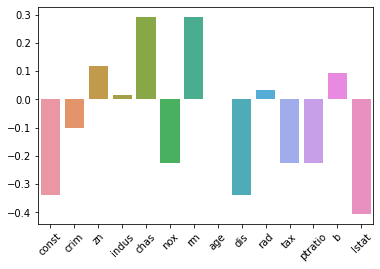

In [394]:
sns.barplot(x=results.params.index, y=results.params)
plt.xticks(rotation=45);

Let's now look at the predictions. We see here that the trend is not bad. By the way, some scattering of points is observed on the left, and also on the right you can see that there are some boundary values 

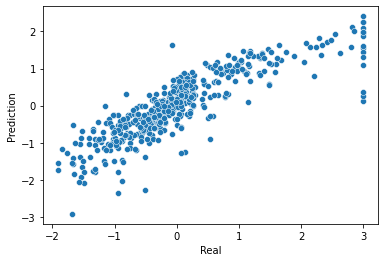

In [395]:
prediction_result = results.get_prediction(x)
target_pred = prediction_result.predicted_mean
sns.scatterplot(y = target_pred, x = target);
plt.xlabel("Real")
plt.ylabel("Prediction");

The greater influence have the *lstat* variable. Lets plot the dependency.

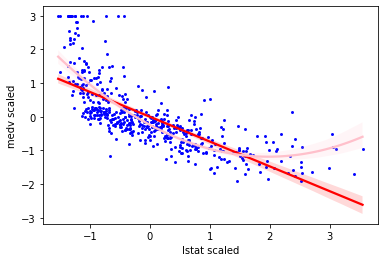

In [396]:
sc_kws = {'color': 'blue', 's': 3}
sns.regplot(y='medv', x='lstat', data=houses_standardized, scatter_kws=sc_kws, line_kws={'color': 'red'}, order = 1);
sns.regplot(y='medv', x='lstat', data=houses_standardized, scatter_kws=sc_kws, line_kws={'color': 'pink'}, order = 2);
plt.xlabel("lstat scaled");
plt.ylabel("medv scaled");

As we can the, there is a real clear dependency. By the way, it is not linear. Maybe it would be better to fit here some exponential decay. In any case, the second order polynom looks much better then the first order one.

### Linear model applicability

Now let's take a closer look at the model residuals. We see here that there is some dependency between residuals and predicted values. So, the variance is not homogenious.

In [397]:
resid = target - target_pred

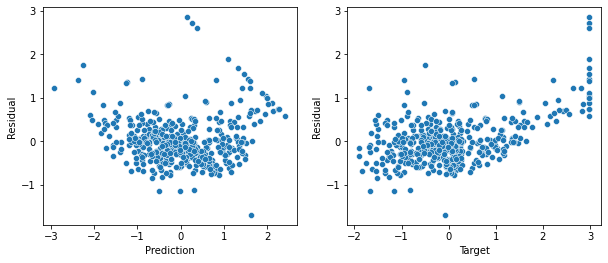

In [398]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

sns.scatterplot(x=target_pred, y=resid, ax=ax1)
ax1.set_xlabel("Prediction");
ax1.set_ylabel("Residual");

sns.scatterplot(x=target, y=resid, ax=ax2, )
ax2.set_xlabel("Target");
ax2.set_ylabel("Residual");

Do the residuals distribute normaly?

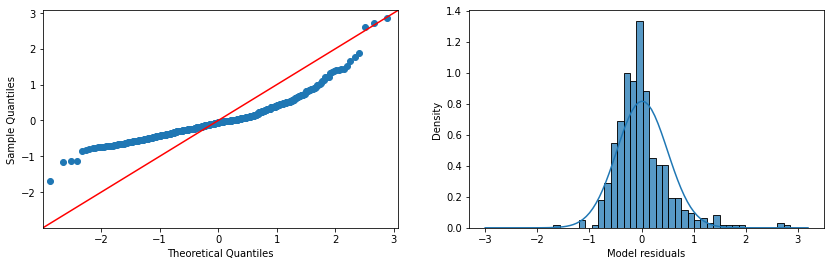

In [399]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

sm.qqplot(resid, line='45', ax=ax1);
ax2.plot();

ax2 = sns.histplot(resid, stat='density');

x = np.random.normal(resid.mean(), resid.std(), size=1000)
mu, std = stats.norm.fit(x)
xx = np.linspace(*ax.get_xlim(),100)
ax2.plot(xx, stats.norm.pdf(xx, mu, std));
ax2.set_xlabel('Model residuals');

Here we clearly see, that residuals are not normaly distributed.

Moreover, some features are correlated.

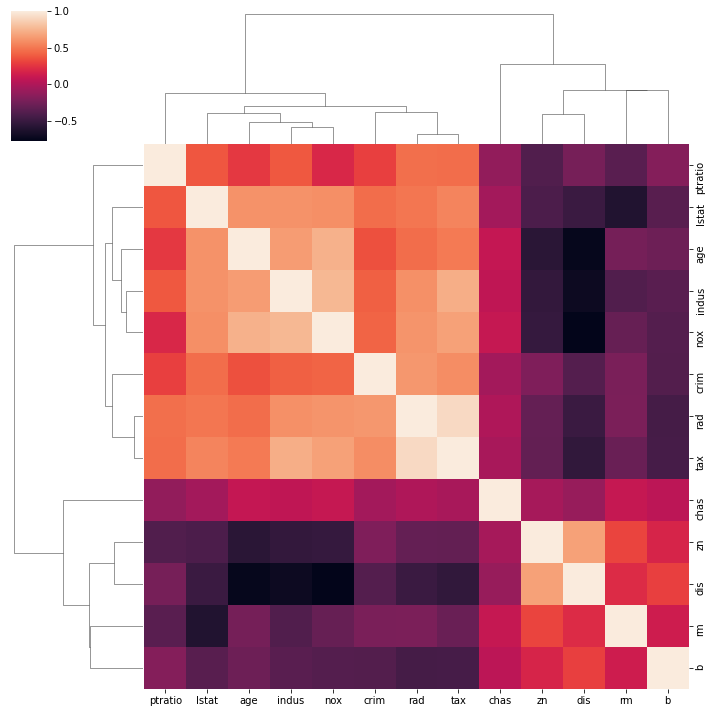

In [400]:
sns.clustermap(features.corr());

## Model improvement

### Observations clean up

Let's check whether there are some outstanding observagtions and drop them

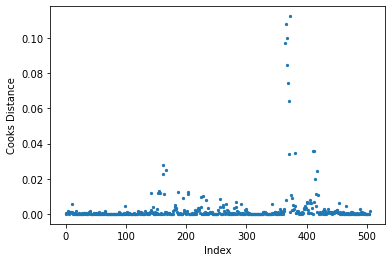

In [442]:
influence = results_upd.get_influence()

cooks = influence.cooks_distance
plt.scatter (houses_standardized.index,cooks[0], s=5)
plt.xlabel('Index')
plt.ylabel('Cooks Distance')
plt.show()

In [464]:
houses_cooked = houses_standardized[cooks[0] < 0.02];

In [465]:
target = houses_cooked.medv
features =  houses_cooked.drop('medv', axis=1, inplace=False)

### Features clean up

Let's try to somehow improve the model to get better results. Firstly, we will frop some correlated features basing on VIF.

In [467]:
def calculate_vif(x):
    vif_data = pd.DataFrame()
    vif_data["feature"] = x.columns
    vif_data["vif"] = [variance_inflation_factor(x.values, i)
                            for i in range(len(x.columns))]

    return vif_data

def purge_the_muck(features, bad_vif=5):
    clean_features = deepcopy(features)
    max_vif = 10
    while max_vif > bad_vif:
        vifs = calculate_vif(clean_features)
        max_vif = max(vifs.vif)
        muck_feature = vifs[vifs.vif == max_vif].feature
        clean_features.drop(muck_feature, inplace = True, axis = 1)
    return clean_features

In [474]:
clean_features = purge_the_muck(features, bad_vif=2)
clean_features = clean_features.apply(standardize)

x = sm.add_constant(clean_features)
model_upd = sm.OLS(target, x)
results_upd = model_upd.fit()

prediction_result_upd = results_upd.get_prediction(x)
target_pred_upd = prediction_result_upd.predicted_mean
resid_upd = target - target_pred_upd

print(results_upd.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     253.6
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          2.58e-157
Time:                        20:10:15   Log-Likelihood:                -284.10
No. Observations:                 491   AIC:                             584.2
Df Residuals:                     483   BIC:                             617.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0413      0.020     -2.104      0.0

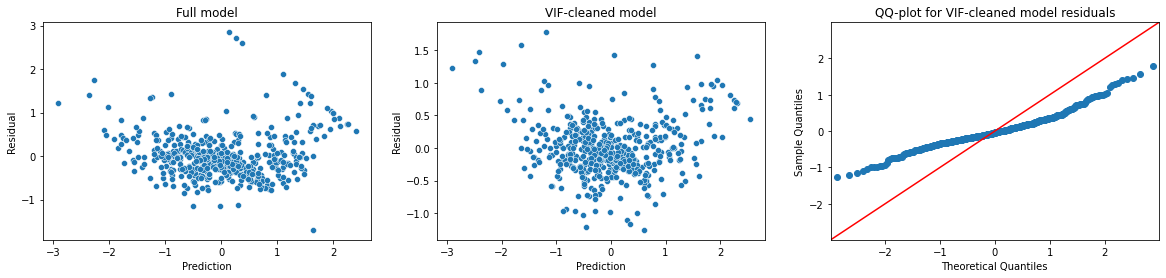

In [447]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4))

sns.scatterplot(x=target_pred, y=resid, ax=ax1)
ax1.set_title('Full model')
ax1.set_xlabel("Prediction");
ax1.set_ylabel("Residual");

sns.scatterplot(x=target_pred_upd, y=resid_upd, ax=ax2)
ax2.set_title('VIF-cleaned model')
ax2.set_xlabel("Prediction");
ax2.set_ylabel("Residual");

sm.qqplot(resid_upd, line='45', ax=ax3);
ax3.set_title('QQ-plot for VIF-cleaned model residuals');

Once again, there aresome problems with the model. The residuals are not normaly distributed.

In [518]:
print(f'The residuals are not from normal law with the p-value {stats.shapiro(resid_upd).pvalue :.3g}')

The residuals are not from normal law with the p-value 3.2e-09


So, it is not improved the model such much. I've also tried to do BoxCox transform of several features with `stats.boxcox` function, but nothing good happend. I can draw several conclusions:

- The model is still unapplicable. So our conclusions based on it not really reliable.
- There is a very strong correlation between features. With VIF-based approach we filtered some of them. The following features remain: CRIM, CHAS, RM, AGE, RAD, PTRATIO, B.  
- From theese features, with the last model we can, the most important ones are RM, PTRATIO, B, AGE and CRIM. There is a pairplot below to illustrate the dependencies. 
- So, the ideal house should have more rooms and should be more new. Also, the less criminal places are more attractive.
- In order to get some more statisticaly prooved results, I would suggest doing some feature transformation, or even use something non-parametric: maybe Kruskal–Wallis with post-hoc Mann-Whitney.
- Finally, we can suggest the following districts where one can invest to build a house: Back Bay, Fenway-Kenmo, South End, South Boston, Kupchino

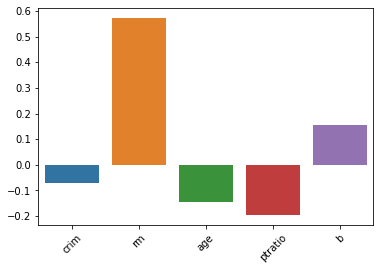

In [537]:
sns.barplot(x=results_upd.params.index[abs(results_upd.params) > 0.06], y=results_upd.params[abs(results_upd.params) > 0.06])
plt.xticks(rotation=45);

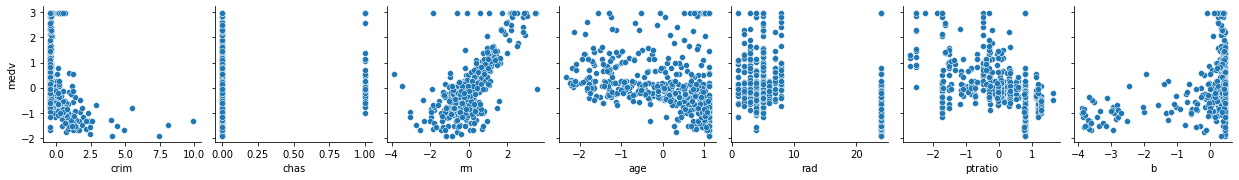

In [527]:
uncorrelated_vars = ['crim', 'chas', 'rm', 'age', 'rad', 'ptratio', 'b']
sns.pairplot(data=houses, y_vars = 'medv', x_vars=uncorrelated_vars);